# Training a neural network with McSnow output

This script applies a DNN to a regression problem 

Much of this follows the basic regression example from the Tensorflow tutorial

https://www.tensorflow.org/tutorials/keras/regression


In [1]:
version  = '27'

### Load Tensorflow and other useful modules

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

import pathlib

import pandas as pd
import seaborn as sns

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt

print(tf.__version__)

2.1.0


In [3]:
tf.random.set_seed(1234)

### Load data from netcdf

In [4]:
import numpy as np
import xarray as xr

In [5]:
mdir='/Users/axel/DWD/GITLAB/mcsnow/'
edir='experiments/'

data = 'ice'
fname1=mdir+edir+'icebox_train_rc_'+data+'.nc'

ds1 = xr.open_dataset(fname1)
print('ds1: ', ds1)

ds1:  <xarray.Dataset>
Dimensions:                        (cell: 2483775)
Dimensions without coordinates: cell
Data variables: (12/204)
    time                           (cell) float32 ...
    q_cloud                        (cell) float32 ...
    n_cloud                        (cell) float32 ...
    q_rain                         (cell) float32 ...
    n_rain                         (cell) float32 ...
    q_ice                          (cell) float32 ...
    ...                             ...
    frze_graupel_rain_mass         (cell) float32 ...
    frze_graupel_rain_rmass        (cell) float32 ...
    frze_graupel_rain_rvol         (cell) float32 ...
    frze_graupel_rain_liq          (cell) float32 ...
    rime_graupel_rain_num          (cell) float32 ...
    rime_graupel_rain_mass         (cell) float32 ...
Attributes:
    title:    McSnow ice microphysics box model output pre-processed by NCL
    date:     Mo 30 Mai 2022 00:45:20 CEST
    nfiles:   10013


# Prepare data for training

In [6]:
def read_and_prepare_data(fname):
    # Read some data, we just want simple nparrays. Hence the .values
    temp = xr.open_dataset(fname).temp.values
    rho  = xr.open_dataset(fname).rho.values
    qi   = xr.open_dataset(fname).q_ice.values
    ni   = xr.open_dataset(fname).n_ice.values
    ssi  = xr.open_dataset(fname).ssi.values
    cwc  = xr.open_dataset(fname).cwc.values
    # process rates
    self_ice_num  = xr.open_dataset(fname).self_ice_num.values
    self_ice_mass = xr.open_dataset(fname).self_ice_mass.values
    # some numerical lower bounds
    q_min = 1e-12
    n_min = 1e-12
    z_min = 1e-20
    p_min = 1e-20
    # transform everything in log space
    ni = np.log(ni, where=ni>n_min, out=np.nan*ni)
    qi = np.log(qi, where=qi>q_min, out=np.nan*qi)
    self_ice_num  = np.log(self_ice_num,  where=self_ice_num>p_min, out=np.nan*self_ice_num)    
    self_ice_mass = np.log(self_ice_mass, where=self_ice_mass>p_min, out=np.nan*self_ice_mass)
    # put everything in a pandas dataframe
    dataset = pd.DataFrame(np.array( [ qi, ni, temp, rho, ssi, self_ice_num, self_ice_mass ]))
    dataset = dataset.T
    dataset.columns = [ 'qi', 'ni', 'temp', 'rho', 'ssi', 'self_ice_num', 'self_ice_mass' ] 
    # remove missing values immediately
    dataset = dataset.dropna()
    return dataset

In [7]:
df = read_and_prepare_data(fname1)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater


In [8]:
df.describe()

qi            ni          temp           rho           ssi  \
count  1.731824e+06  1.731824e+06  1.731824e+06  1.731824e+06  1.731824e+06   
mean  -8.271086e+00  1.462456e+01  2.377350e+02  6.402268e-01  4.354293e-03   
std    1.320175e+00  2.346545e+00  1.069314e+01  1.210146e-01  1.410410e-02   
min   -1.926117e+01  2.014369e+00  2.066500e+02  4.120000e-01 -5.100000e-03   
25%   -9.095674e+00  1.288029e+01  2.299100e+02  5.440000e-01  2.100000e-03   
50%   -8.326531e+00  1.451357e+01  2.387200e+02  6.420000e-01  3.000000e-03   
75%   -7.354121e+00  1.634411e+01  2.454800e+02  7.230000e-01  3.900000e-03   
max   -4.315790e+00  2.052169e+01  2.736900e+02  1.254000e+00  3.028000e-01   

       self_ice_num  self_ice_mass  
count  1.731824e+06   1.731824e+06  
mean   3.165429e+00  -1.841665e+01  
std    2.308700e+00   1.950461e+00  
min   -1.680119e+01  -4.022096e+01  
25%    1.722767e+00  -1.945680e+01  
50%    3.242592e+00  -1.838312e+01  
75%    4.689511e+00  -1.724597e+01  
max    1.021327e+01  -1.152849e+01

### Split in training, testing and validation with 70/15/15 rule

In [9]:
msk = np.random.rand(len(df)) < 0.7
dataset_train = df[msk]

df2 = df[~msk]
msk = np.random.rand(len(df2)) < 0.5

dataset_test = df2[msk]
dataset_val = df2[~msk]

### Inspect the data

In [10]:
dataset_train.head()

qi         ni        temp    rho     ssi  self_ice_num  self_ice_mass
1 -9.098263  11.622676  243.710007  0.699  0.0098      1.568616     -17.866796
2 -9.102742  11.618186  243.779999  0.700  0.0098      1.386294     -18.022005
3 -9.107783  11.613495  243.850006  0.701  0.0098      2.079442     -17.207029
5 -9.115394  11.605140  244.000000  0.703  0.0098      2.028148     -17.210222
6 -9.117306  11.601485  244.070007  0.704  0.0098      1.568616     -17.678186

In [11]:
dataset_train.describe()

qi            ni          temp           rho           ssi  \
count  1.212745e+06  1.212745e+06  1.212745e+06  1.212745e+06  1.212745e+06   
mean  -8.271204e+00  1.462358e+01  2.377330e+02  6.401672e-01  4.347227e-03   
std    1.319396e+00  2.345761e+00  1.068466e+01  1.208854e-01  1.404840e-02   
min   -1.926117e+01  2.014369e+00  2.066500e+02  4.120000e-01 -5.100000e-03   
25%   -9.095406e+00  1.287968e+01  2.299200e+02  5.440000e-01  2.100000e-03   
50%   -8.326696e+00  1.451115e+01  2.387200e+02  6.420000e-01  3.000000e-03   
75%   -7.355278e+00  1.634196e+01  2.454700e+02  7.230000e-01  3.900000e-03   
max   -4.325495e+00  2.052169e+01  2.736900e+02  1.216000e+00  3.011000e-01   

       self_ice_num  self_ice_mass  
count  1.212745e+06   1.212745e+06  
mean   3.165210e+00  -1.841620e+01  
std    2.307524e+00   1.949159e+00  
min   -1.680119e+01  -4.003572e+01  
25%    1.722767e+00  -1.945715e+01  
50%    3.242592e+00  -1.838337e+01  
75%    4.689511e+00  -1.724630e+01  
max    1.021327e+01  -1.152849e+01

In [12]:
dataset_test.describe()

qi             ni           temp            rho  \
count  259375.000000  259375.000000  259375.000000  259375.000000   
mean       -8.271410      14.626206     237.748062       0.640452   
std         1.323772       2.350519      10.722659       0.121434   
min       -18.520899       2.661168     206.720001       0.413000   
25%        -9.095406      12.877409     229.880005       0.544000   
50%        -8.324097      14.522018     238.720001       0.642000   
75%        -7.350035      16.354511     245.520004       0.723000   
max        -4.315790      20.516758     273.589996       1.219000   

                 ssi   self_ice_num  self_ice_mass  
count  259375.000000  259375.000000  259375.000000  
mean        0.004354       3.165305     -18.417643  
std         0.014092       2.314608       1.955751  
min        -0.004300     -16.801191     -40.220959  
25%         0.002100       1.722767     -19.453912  
50%         0.003000       3.242592     -18.379290  
75%         0.003900       4.689511     -17.248256  
max         0.302800      10.074006     -11.675879

In [13]:
dataset_val.describe()

qi             ni           temp            rho  \
count  259704.000000  259704.000000  259704.000000  259704.000000   
mean       -8.270203      14.627423     237.731903       0.640279   
std         1.320219       2.346238      10.703253       0.121198   
min       -17.833950       4.080770     206.860001       0.412000   
25%        -9.097012      12.885463     229.860001       0.544000   
50%        -8.328351      14.516626     238.710007       0.643000   
75%        -7.353382      16.343157     245.490005       0.723000   
max        -4.376045      20.521381     273.579987       1.254000   

                 ssi   self_ice_num  self_ice_mass  
count  259704.000000  259704.000000  259704.000000  
mean        0.004387       3.166587     -18.417765  
std         0.014374       2.308286       1.951258  
min        -0.004100     -16.536806     -38.655384  
25%         0.002100       1.722767     -19.458073  
50%         0.003000       3.242592     -18.385667  
75%         0.003900       4.689511     -17.242921  
max         0.298500      10.014528     -11.595633

### Further reduce data to relevant parameter range

In [14]:
def reduce_data(dataset):
    idx = dataset[ dataset['qi'] < -20 ].index
    dataset.drop(idx,inplace=True)   
    idx = dataset[ dataset['temp'] > 273 ].index
    dataset.drop(idx,inplace=True)   
    return dataset

In [15]:
dataset_test  = reduce_data(dataset_test)
dataset_train = reduce_data(dataset_train)
dataset_val   = reduce_data(dataset_val)

/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [16]:
dataset_train.describe()

qi            ni          temp           rho           ssi  \
count  1.212134e+06  1.212134e+06  1.212134e+06  1.212134e+06  1.212134e+06   
mean  -8.269753e+00  1.462607e+01  2.377150e+02  6.399140e-01  4.349725e-03   
std    1.317451e+00  2.343088e+00  1.065759e+01  1.203842e-01  1.405146e-02   
min   -1.926117e+01  2.014369e+00  2.066500e+02  4.120000e-01  0.000000e+00   
25%   -9.094337e+00  1.288205e+01  2.299100e+02  5.440000e-01  2.200000e-03   
50%   -8.325953e+00  1.451270e+01  2.387100e+02  6.420000e-01  3.000000e-03   
75%   -7.354839e+00  1.634292e+01  2.454600e+02  7.230000e-01  3.900000e-03   
max   -4.325495e+00  2.052169e+01  2.730000e+02  1.205000e+00  3.011000e-01   

       self_ice_num  self_ice_mass  
count  1.212134e+06   1.212134e+06  
mean   3.167665e+00  -1.841451e+01  
std    2.304515e+00   1.946923e+00  
min   -1.680119e+01  -4.003572e+01  
25%    1.722767e+00  -1.945565e+01  
50%    3.242592e+00  -1.838249e+01  
75%    4.689511e+00  -1.724565e+01  
max    1.010358e+01  -1.152849e+01

In [17]:
dataset_test.describe()

qi             ni           temp            rho  \
count  259225.000000  259225.000000  259225.000000  259225.000000   
mean       -8.269743      14.629184     237.727509       0.640160   
std         1.321514       2.347220      10.691710       0.120859   
min       -18.520899       2.661168     206.720001       0.413000   
25%        -9.094515      12.880164     229.869995       0.543000   
50%        -8.323190      14.524137     238.710007       0.642000   
75%        -7.349475      16.355537     245.509995       0.723000   
max        -4.315790      20.516758     273.000000       1.205000   

                 ssi   self_ice_num  self_ice_mass  
count  259225.000000  259225.000000  259225.000000  
mean        0.004357       3.168115     -18.415802  
std         0.014095       2.311182       1.953332  
min         0.000000     -16.801191     -40.220959  
25%         0.002100       1.722767     -19.452236  
50%         0.003000       3.242592     -18.378359  
75%         0.003900       4.689511     -17.247545  
max         0.302800      10.074006     -11.675879

### Pairplot

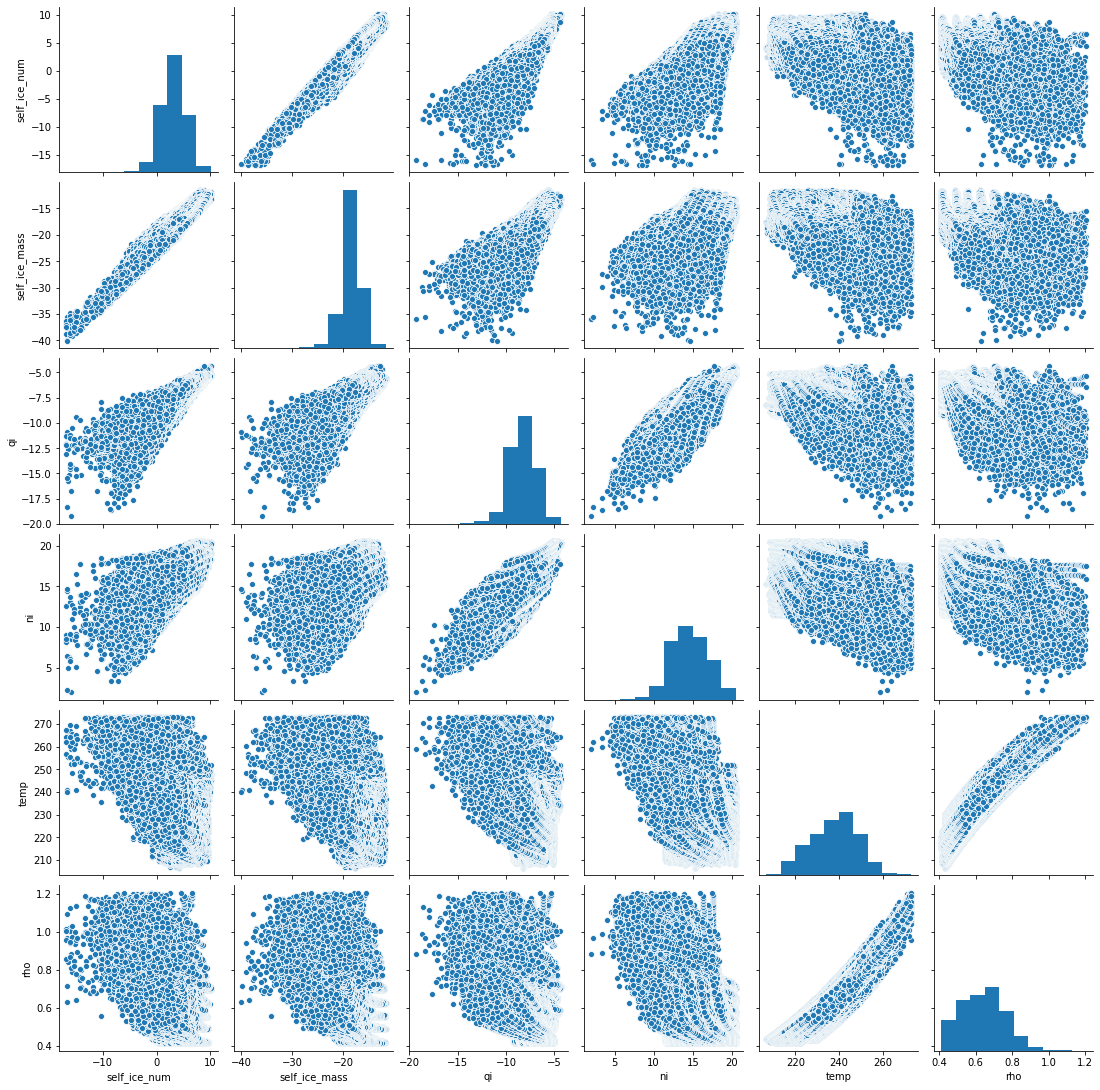

In [18]:
sns.pairplot(dataset_train[["self_ice_num","self_ice_mass","qi","ni","temp","rho"]], diag_kind="hist")

## Separate in different dataset with selected sets of predictors

In [19]:
train_dataset1 = dataset_train.copy()
train_dataset2 = dataset_train.copy()
train_dataset3 = dataset_train.copy()
train_dataset4 = dataset_train.copy()
train_dataset5 = dataset_train.copy()

In [20]:
test_dataset1 = dataset_test.copy()
test_dataset2 = dataset_test.copy()
test_dataset3 = dataset_test.copy()
test_dataset4 = dataset_test.copy()
test_dataset5 = dataset_test.copy()

In [21]:
val_dataset1 = dataset_val.copy()
val_dataset2 = dataset_val.copy()
val_dataset3 = dataset_val.copy()
val_dataset4 = dataset_val.copy()
val_dataset5 = dataset_val.copy()

In [22]:
train_dataset1 = train_dataset1.drop(['temp','rho','ssi'], axis=1)
train_dataset2 = train_dataset2.drop(['rho','ssi'], axis=1)
train_dataset3 = train_dataset3.drop(['ssi'], axis=1)
#train_dataset4 = train_dataset4.drop(['zi'], axis=1)
#train_dataset5 = train_dataset5.drop(['qs'], axis=1)

In [23]:
test_dataset1 = test_dataset1.drop(['temp','rho','ssi'], axis=1)
test_dataset2 = test_dataset2.drop(['rho','ssi'], axis=1)
test_dataset3 = test_dataset3.drop(['ssi'], axis=1)
#test_dataset4 = test_dataset4.drop(['zi'], axis=1)
#test_dataset5 = test_dataset5.drop(['qs'], axis=1)

In [24]:
val_dataset1 = val_dataset1.drop(['temp','rho','ssi'], axis=1)
val_dataset2 = val_dataset2.drop(['rho','ssi'], axis=1)
val_dataset3 = val_dataset3.drop(['ssi'], axis=1)
#val_dataset4 = val_dataset4.drop(['zi'], axis=1)
#val_dataset5 = val_dataset5.drop(['qs'], axis=1)

In [25]:
train_stats1 = train_dataset1.describe()
train_stats1.pop("self_ice_num")
train_stats1.pop("self_ice_mass")
train_stats1 = train_stats1.transpose()
train_stats1

count       mean       std        min        25%        50%  \
qi  1212134.0  -8.269753  1.317451 -19.261169  -9.094337  -8.325953   
ni  1212134.0  14.626071  2.343088   2.014369  12.882049  14.512699   

          75%        max  
qi  -7.354839  -4.325495  
ni  16.342918  20.521688

In [26]:
train_stats2 = train_dataset2.describe()
train_stats2.pop("self_ice_num")
train_stats2.pop("self_ice_mass")
train_stats2 = train_stats2.transpose()
train_stats2

count        mean        std         min         25%         50%  \
qi    1212134.0   -8.269753   1.317451  -19.261169   -9.094337   -8.325953   
ni    1212134.0   14.626071   2.343088    2.014369   12.882049   14.512699   
temp  1212134.0  237.714951  10.657585  206.649994  229.910004  238.710007   

             75%         max  
qi     -7.354839   -4.325495  
ni     16.342918   20.521688  
temp  245.460007  273.000000

In [27]:
train_stats3 = train_dataset3.describe()
train_stats3.pop("self_ice_num")
train_stats3.pop("self_ice_mass")
train_stats3 = train_stats3.transpose()
train_stats3

count        mean        std         min         25%         50%  \
qi    1212134.0   -8.269753   1.317451  -19.261169   -9.094337   -8.325953   
ni    1212134.0   14.626071   2.343088    2.014369   12.882049   14.512699   
temp  1212134.0  237.714951  10.657585  206.649994  229.910004  238.710007   
rho   1212134.0    0.639914   0.120384    0.412000    0.544000    0.642000   

             75%         max  
qi     -7.354839   -4.325495  
ni     16.342918   20.521688  
temp  245.460007  273.000000  
rho     0.723000    1.205000

In [28]:
train_stats4 = train_dataset4.describe()
train_stats4.pop("self_ice_num")
train_stats4.pop("self_ice_mass")
train_stats4 = train_stats4.transpose()
train_stats4

count        mean        std         min         25%         50%  \
qi    1212134.0   -8.269753   1.317451  -19.261169   -9.094337   -8.325953   
ni    1212134.0   14.626071   2.343088    2.014369   12.882049   14.512699   
temp  1212134.0  237.714951  10.657585  206.649994  229.910004  238.710007   
rho   1212134.0    0.639914   0.120384    0.412000    0.544000    0.642000   
ssi   1212134.0    0.004350   0.014051    0.000000    0.002200    0.003000   

             75%         max  
qi     -7.354839   -4.325495  
ni     16.342918   20.521688  
temp  245.460007  273.000000  
rho     0.723000    1.205000  
ssi     0.003900    0.301100

In [29]:
train_stats5 = train_dataset5.describe()
train_stats5.pop("self_ice_num")
train_stats5.pop("self_ice_mass")
train_stats5 = train_stats5.transpose()
train_stats5

count        mean        std         min         25%         50%  \
qi    1212134.0   -8.269753   1.317451  -19.261169   -9.094337   -8.325953   
ni    1212134.0   14.626071   2.343088    2.014369   12.882049   14.512699   
temp  1212134.0  237.714951  10.657585  206.649994  229.910004  238.710007   
rho   1212134.0    0.639914   0.120384    0.412000    0.544000    0.642000   
ssi   1212134.0    0.004350   0.014051    0.000000    0.002200    0.003000   

             75%         max  
qi     -7.354839   -4.325495  
ni     16.342918   20.521688  
temp  245.460007  273.000000  
rho     0.723000    1.205000  
ssi     0.003900    0.301100

### Split features from labels (here we need only one set of labels)

Separate the target value, or "label", from the features. This label is the value that you will train the model to predict.

In [30]:
# pop does not work for multiple columns, use copy instead

labels = ['self_ice_num','self_ice_mass']

train_labels = train_dataset1[labels].copy()
train_dataset1.drop(labels, axis=1, inplace=True)

test_labels = test_dataset1[labels].copy()
test_dataset1.drop(labels, axis=1, inplace=True)

val_labels = val_dataset1[labels].copy()
val_dataset1.drop(labels, axis=1, inplace=True)

In [31]:
train_dataset2.drop(labels, axis=1, inplace=True)
test_dataset2.drop(labels, axis=1, inplace=True)
val_dataset2.drop(labels, axis=1, inplace=True)

In [32]:
train_dataset3.drop(labels, axis=1, inplace=True)
test_dataset3.drop(labels, axis=1, inplace=True)
val_dataset3.drop(labels, axis=1, inplace=True)

In [33]:
train_dataset4.drop(labels, axis=1, inplace=True)
test_dataset4.drop(labels, axis=1, inplace=True)
val_dataset4.drop(labels, axis=1, inplace=True)

In [34]:
train_dataset5.drop(labels, axis=1, inplace=True)
test_dataset5.drop(labels, axis=1, inplace=True)
val_dataset5.drop(labels, axis=1, inplace=True)

In [35]:
train_labels.describe()

self_ice_num  self_ice_mass
count  1.212134e+06   1.212134e+06
mean   3.167665e+00  -1.841451e+01
std    2.304515e+00   1.946923e+00
min   -1.680119e+01  -4.003572e+01
25%    1.722767e+00  -1.945565e+01
50%    3.242592e+00  -1.838249e+01
75%    4.689511e+00  -1.724565e+01
max    1.010358e+01  -1.152849e+01

In [36]:
train_dataset1.describe()

qi            ni
count  1.212134e+06  1.212134e+06
mean  -8.269753e+00  1.462607e+01
std    1.317451e+00  2.343088e+00
min   -1.926117e+01  2.014369e+00
25%   -9.094337e+00  1.288205e+01
50%   -8.325953e+00  1.451270e+01
75%   -7.354839e+00  1.634292e+01
max   -4.325495e+00  2.052169e+01

In [37]:
train_dataset2.describe()

qi            ni          temp
count  1.212134e+06  1.212134e+06  1.212134e+06
mean  -8.269753e+00  1.462607e+01  2.377150e+02
std    1.317451e+00  2.343088e+00  1.065759e+01
min   -1.926117e+01  2.014369e+00  2.066500e+02
25%   -9.094337e+00  1.288205e+01  2.299100e+02
50%   -8.325953e+00  1.451270e+01  2.387100e+02
75%   -7.354839e+00  1.634292e+01  2.454600e+02
max   -4.325495e+00  2.052169e+01  2.730000e+02

In [38]:
train_dataset3.describe()

qi            ni          temp           rho
count  1.212134e+06  1.212134e+06  1.212134e+06  1.212134e+06
mean  -8.269753e+00  1.462607e+01  2.377150e+02  6.399140e-01
std    1.317451e+00  2.343088e+00  1.065759e+01  1.203842e-01
min   -1.926117e+01  2.014369e+00  2.066500e+02  4.120000e-01
25%   -9.094337e+00  1.288205e+01  2.299100e+02  5.440000e-01
50%   -8.325953e+00  1.451270e+01  2.387100e+02  6.420000e-01
75%   -7.354839e+00  1.634292e+01  2.454600e+02  7.230000e-01
max   -4.325495e+00  2.052169e+01  2.730000e+02  1.205000e+00

### Normalize the features

In [39]:
def norm(x,stats):
  return (x - stats['mean']) / stats['std']

normed_train_data1 = norm(train_dataset1,train_stats1)
normed_train_data2 = norm(train_dataset2,train_stats2)
normed_train_data3 = norm(train_dataset3,train_stats3)
normed_train_data4 = norm(train_dataset4,train_stats4)
normed_train_data5 = norm(train_dataset5,train_stats5)

normed_test_data1 = norm(test_dataset1,train_stats1)
normed_test_data2 = norm(test_dataset2,train_stats2)
normed_test_data3 = norm(test_dataset3,train_stats3)
normed_test_data4 = norm(test_dataset4,train_stats4)
normed_test_data5 = norm(test_dataset5,train_stats5)

normed_val_data1 = norm(val_dataset1,train_stats1)
normed_val_data2 = norm(val_dataset2,train_stats2)
normed_val_data3 = norm(val_dataset3,train_stats3)
normed_val_data4 = norm(val_dataset4,train_stats4)
normed_val_data5 = norm(val_dataset5,train_stats5)

In [40]:
normed_train_stats1 = normed_train_data1.describe()
normed_train_stats1 = normed_train_stats1.transpose()
normed_train_stats1

count          mean  std       min       25%       50%       75%  \
qi  1212134.0  8.151534e-07  1.0 -8.342944 -0.625894 -0.042659  0.694457   
ni  1212134.0 -1.796340e-06  1.0 -5.382514 -0.744327 -0.048386  0.732729   

         max  
qi  2.993856  
ni  2.516175

In [41]:
normed_train_stats2 = normed_train_data2.describe()
normed_train_stats2 = normed_train_stats2.transpose()
normed_train_stats2

count          mean  std       min       25%       50%       75%  \
qi    1212134.0  8.151534e-07  1.0 -8.342944 -0.625894 -0.042659  0.694457   
ni    1212134.0 -1.796340e-06  1.0 -5.382514 -0.744327 -0.048386  0.732729   
temp  1212134.0  5.606309e-06  1.0 -2.914821 -0.732337  0.093366  0.726718   

           max  
qi    2.993856  
ni    2.516175  
temp  3.310792

In [42]:
normed_train_stats3 = normed_train_data3.describe()
normed_train_stats3 = normed_train_stats3.transpose()
normed_train_stats3

count          mean  std       min       25%       50%       75%  \
qi    1212134.0  8.151534e-07  1.0 -8.342944 -0.625894 -0.042659  0.694457   
ni    1212134.0 -1.796340e-06  1.0 -5.382514 -0.744327 -0.048386  0.732729   
temp  1212134.0  5.606309e-06  1.0 -2.914821 -0.732337  0.093366  0.726718   
rho   1212134.0 -2.299313e-07  1.0 -1.893221 -0.796732  0.017328  0.690174   

           max  
qi    2.993856  
ni    2.516175  
temp  3.310792  
rho   4.694021

In [43]:
normed_train_stats4 = normed_train_data4.describe()
normed_train_stats4 = normed_train_stats4.transpose()
normed_train_stats4

count          mean  std       min       25%       50%       75%  \
qi    1212134.0  8.151534e-07  1.0 -8.342944 -0.625894 -0.042659  0.694457   
ni    1212134.0 -1.796340e-06  1.0 -5.382514 -0.744327 -0.048386  0.732729   
temp  1212134.0  5.606309e-06  1.0 -2.914821 -0.732337  0.093366  0.726718   
rho   1212134.0 -2.299313e-07  1.0 -1.893221 -0.796732  0.017328  0.690174   
ssi   1212134.0 -4.441022e-09  1.0 -0.309557 -0.152989 -0.096056 -0.032006   

            max  
qi     2.993856  
ni     2.516175  
temp   3.310792  
rho    4.694021  
ssi   21.118815

In [44]:
normed_train_stats5 = normed_train_data5.describe()
normed_train_stats5 = normed_train_stats5.transpose()
normed_train_stats5

count          mean  std       min       25%       50%       75%  \
qi    1212134.0  8.151534e-07  1.0 -8.342944 -0.625894 -0.042659  0.694457   
ni    1212134.0 -1.796340e-06  1.0 -5.382514 -0.744327 -0.048386  0.732729   
temp  1212134.0  5.606309e-06  1.0 -2.914821 -0.732337  0.093366  0.726718   
rho   1212134.0 -2.299313e-07  1.0 -1.893221 -0.796732  0.017328  0.690174   
ssi   1212134.0 -4.441022e-09  1.0 -0.309557 -0.152989 -0.096056 -0.032006   

            max  
qi     2.993856  
ni     2.516175  
temp   3.310792  
rho    4.694021  
ssi   21.118815

### Normalize the labels

In [45]:
train_labels_stats = train_labels.describe()
train_labels_stats = train_labels_stats.transpose()
train_labels_stats

count       mean       std        min        25%  \
self_ice_num   1212134.0   3.167665  2.304515 -16.801191   1.722767   
self_ice_mass  1212134.0 -18.414513  1.946923 -40.035725 -19.455650   

                     50%        75%        max  
self_ice_num    3.242592   4.689511  10.103583  
self_ice_mass -18.382490 -17.245649 -11.528487

In [46]:
normed_train_labels = norm(train_labels,train_labels_stats)
normed_test_labels = norm(test_labels,train_labels_stats)
normed_val_labels = norm(val_labels,train_labels_stats)

# The model

## Build the model

In [47]:
def build_model_sigm(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='sigmoid', input_shape=[ncol]),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(nsize, activation='sigmoid'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model


def build_model_tanh(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(nsize, activation='tanh'),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# scaled exponential linear unit (Klambauer et al. 2015) with LeCun initialization
def build_model_selu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='tanh', input_shape=[ncol]),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(nsize, activation='selu', kernel_initializer="lecun_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Most common activation piecewise linear function, which should be use with He-initialization
def build_model_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Leaky ReLU with max(alpha*z,z), which helps to avoid dying neurons
def build_model_leaky_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.LeakyReLU(alpha=0.2),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Parametric leaky ReLU with max(alpha*z,z), but alpha is now a trainable parameter
# This has a strongly increased risk of overfitting!
def build_model_param_relu(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, input_shape=[ncol]),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(nsize, kernel_initializer="he_normal"),
    layers.PReLU(),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.RMSprop(learn)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# Here we use the Nesterov Accelerated Gradient (NAG) optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_SGD_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.SGD(lr=learn, momentum=0.9, nesterov=True)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

# and the Adam optimizer (see Chapter 12 of Hands-On ML)
def build_model_relu_Adam_H6(ncol,nsize,learn):
  model = keras.Sequential([
    layers.Dense(nsize, activation='relu', input_shape=[ncol]),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(nsize, activation='relu', kernel_initializer="he_normal"),
    layers.Dense(2)
  ])
  optimizer = tf.keras.optimizers.Adam(lr=learn, beta_1=0.9, beta_2=0.999)
  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

def build_model(ncol,nsize,activation,learning_rate):
    if activation == "sigm":
        model = build_model_sigm(ncol,nsize,learning_rate)
    elif activation == "tanh":
        model = build_model_tanh(ncol,nsize,learning_rate)
    elif activation == "SELU":
        model = build_model_selu(ncol,nsize,learning_rate)
    elif activation == "ReLU":
        model = build_model_relu(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD":
        model = build_model_relu_SGD(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam":
        model = build_model_relu_Adam(ncol,nsize,learning_rate)
    elif activation == "ReLU_SGD_H6":
        model = build_model_relu_SGD_H6(ncol,nsize,learning_rate)
    elif activation == "ReLU_Adam_H6":
        model = build_model_relu_Adam_H6(ncol,nsize,learning_rate)
    elif activation == "LReLU":
        model = build_model_leaky_relu(ncol,nsize,learning_rate)
    elif activation == "PReLU":
        model = build_model_param_relu(ncol,nsize,learning_rate)
    else:
        print("Error: Wrong choice for activation")
    return model        

In [48]:

activ = "sigm"
    
#activ = "PReLU"
#activ = "LReLU"
#activ = "tanh"
#activ = "ReLU_SGD"
#activ = "ReLU_Adam"
#activ = "ReLU"

model = build_model(2,16,activ,1e-3)

### Inspect the model

Use the `.summary` method to print a simple description of the model

In [49]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                48        
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 34        
Total params: 626
Trainable params: 626
Non-trainable params: 0
_________________________________________________________________


Now try out the model. Take a batch of `10` examples from the training data and call `model.predict` on it.

In [50]:
example_batch  = normed_train_data1[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.28809723, -0.8371356 ],
       [-0.2880913 , -0.83713114],
       [-0.28808495, -0.83712655],
       [-0.2880742 , -0.8371178 ],
       [-0.28806984, -0.8371138 ],
       [-0.2880643 , -0.8371091 ],
       [-0.28805968, -0.83710444],
       [-0.2880535 , -0.83709943],
       [-0.2880451 , -0.83709127],
       [-0.28803557, -0.8370815 ]], dtype=float32)

It seems to be working, if it produces a result of the expected shape and type and no NaN.

# Train the model

Use early stopping

In [51]:
# maximum number, but we use early stopping
EPOCHS = 300

# learning rate
learn = 1e-3       # original value is 1e-3, but smaller might be better?

# width of neural net
nsize = 16

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=20)

# for collecting the histories
histories = {}

# make plots bigger than standard layout
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

In [52]:
activ = "ReLU_Adam"
model1 = build_model(len(normed_train_data1.keys()),nsize,activ,learn)

early_history1 = model1.fit(normed_train_data1, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data1,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1529,  mae:0.2868,  mse:0.1529,  val_loss:0.1497,  val_mae:0.2845,  val_mse:0.1497,  
................................................................

Text(0, 0.5, 'MSE')

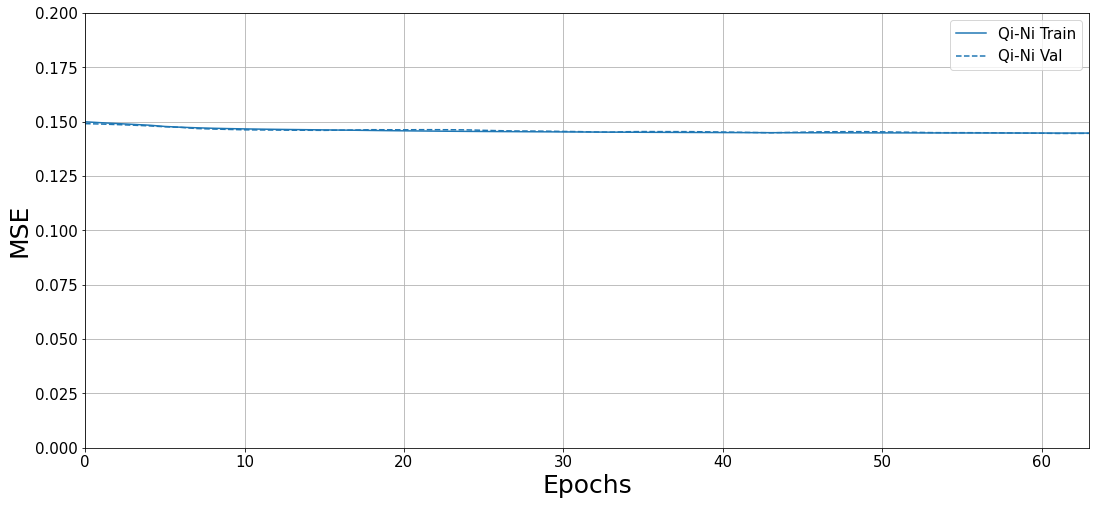

In [55]:
histories['qi-ni'] = early_history1

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.0,0.2])
plt.ylabel('MSE')

In [56]:
activ = "ReLU_Adam"
model2 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history2 = model2.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1396,  mae:0.2712,  mse:0.1396,  val_loss:0.1313,  val_mae:0.2638,  val_mse:0.1313,  
...........................................................................................

In [57]:
histories['qi-ni-T-rho'] = early_history2

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.04, 0.2])
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

In [58]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True, patience=10)

In [59]:
nsize = 32
activ = "ReLU_Adam"
model3 = build_model(len(normed_train_data3.keys()),nsize,activ,learn)

early_history3 = model3.fit(normed_train_data3, normed_train_labels, 
                    epochs=EPOCHS, validation_data=[normed_val_data3,normed_val_labels], verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.1348,  mae:0.2661,  mse:0.1348,  val_loss:0.1286,  val_mae:0.2585,  val_mse:0.1286,  
...............................................

In [61]:
histories['ReLU_Adam_32'] = early_history3

plotter = tfdocs.plots.HistoryPlotter(smoothing_std=1)

plotter.plot(histories, metric = "mse")
plt.ylim([0.1, 0.2])
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

Text(0, 0.5, 'MAE')

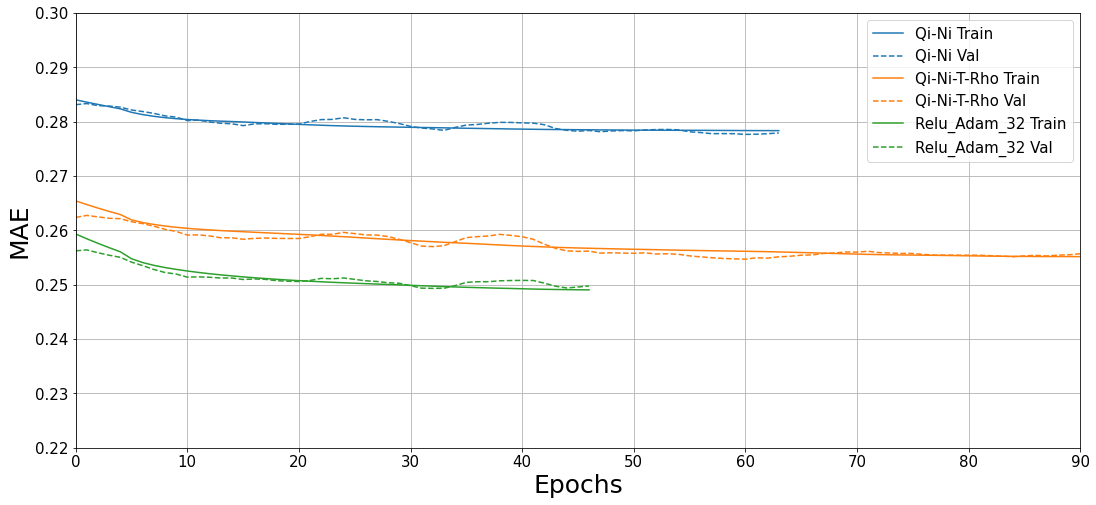

In [65]:
plotter.plot(histories, metric = "mae")
plt.ylim([0.22, 0.3])
plt.ylabel('MAE')

In [66]:
loss1, mae1, mse1 = model1.evaluate(normed_test_data1, normed_test_labels, verbose=2)

print("Testing set for model 1, Mean Abs Error: {:10.5f}".format(mae1))

259225/259225 - 6s - loss: 0.1458 - mae: 0.2792 - mse: 0.1458
Testing set for model 1, Mean Abs Error:    0.27916


In [67]:
loss2, mae2, mse2 = model2.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 2, Mean Abs Error: {:20.5f}".format(mae2))

259225/259225 - 6s - loss: 0.1244 - mae: 0.2555 - mse: 0.1244
Testing set for model 2, Mean Abs Error:              0.25550


In [68]:
loss3, mae3, mse3 = model3.evaluate(normed_test_data3, normed_test_labels, verbose=2)

print("Testing set for model 3, Mean Abs Error: {:20.5f}".format(mae3))

259225/259225 - 6s - loss: 0.1192 - mae: 0.2478 - mse: 0.1192
Testing set for model 3, Mean Abs Error:              0.24782


In [69]:
mae = [ mae1, mae2, mae3 ]
mae

[0.27916408, 0.25550157, 0.24781795]

In [70]:
mse = [ mse1, mse2, mse3 ]
mse

[0.14580373, 0.12440758, 0.11916263]

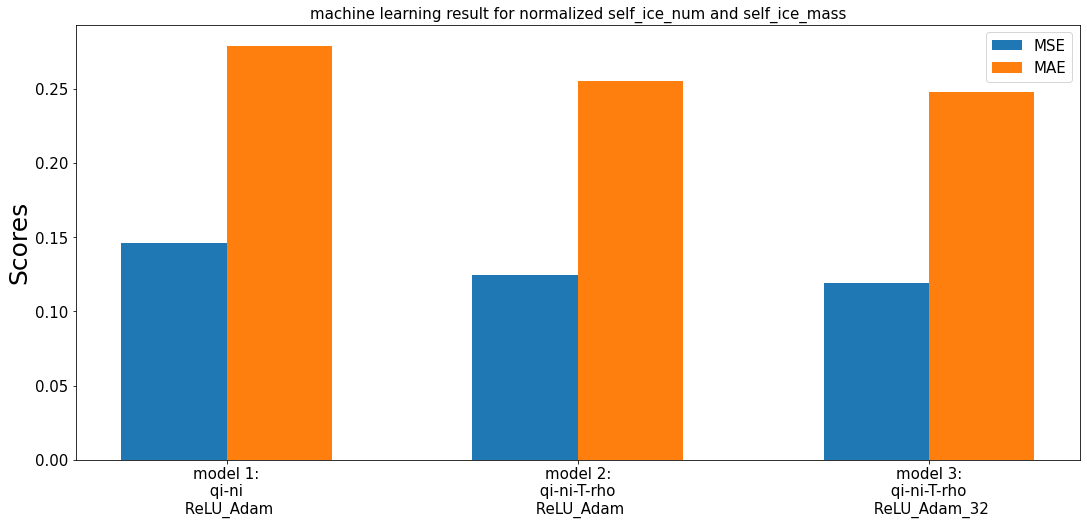

In [71]:
SMALL_SIZE = 15
MEDIUM_SIZE = 25
BIGGER_SIZE = 25

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize

plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

labels = ['model 1:\n qi-ni \n ReLU_Adam',
 'model 2:\n qi-ni-T-rho \n ReLU_Adam',
 'model 3:\n qi-ni-T-rho \n ReLU_Adam_32' ]

x = np.arange(len(labels))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, mse, width, label='MSE')
rects2 = ax.bar(x + width/2, mae, width, label='MAE')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('machine learning result for normalized self_ice_num and self_ice_mass')
ax.set_xticks(x)
ax.set_xticklabels(labels)
#ax.set_ylim(0,3e-8)
ax.legend()

#fig.tight_layout()

plt.show()

# Make predictions

Finally, predict the values using data in the testing set:

In [72]:
test_true_self_ice_num  = np.exp(test_labels.pop('self_ice_num'))
test_true_self_ice_mass = np.exp(test_labels.pop('self_ice_mass'))

In [73]:
def backtransform(x,stats):
  return x*stats['std']+stats['mean']

In [74]:
p1 = pd.DataFrame(data=model1.predict(normed_test_data1), columns=["self_ice_num", "self_ice_mass"])

In [75]:
p1.describe()

self_ice_num  self_ice_mass
count  259225.000000  259225.000000
mean       -0.007150      -0.006345
std         0.936111       0.893394
min        -4.655565      -5.576284
25%        -0.640322      -0.498921
50%         0.024671      -0.021110
75%         0.650682       0.535386
max         2.779362       3.448877

In [76]:
train_labels_stats

count       mean       std        min        25%  \
self_ice_num   1212134.0   3.167665  2.304515 -16.801191   1.722767   
self_ice_mass  1212134.0 -18.414513  1.946923 -40.035725 -19.455650   

                     50%        75%        max  
self_ice_num    3.242592   4.689511  10.103583  
self_ice_mass -18.382490 -17.245649 -11.528487

In [77]:
test_predict1 = np.exp(backtransform(p1,train_labels_stats))

In [78]:
test_predict1.describe()

self_ice_num  self_ice_mass
count  259225.000000   2.592250e+05
mean      159.144259   4.371977e-08
std       475.704483   1.627697e-07
min         0.000520   1.939629e-13
25%         5.430515   3.809095e-09
50%        25.141501   9.656721e-09
75%       106.396361   2.853433e-08
max     14367.802521   8.295357e-06

In [79]:
test_predict1_self_ice_num  = test_predict1['self_ice_num']
test_predict1_self_ice_mass = test_predict1['self_ice_mass']

In [80]:

p2 = pd.DataFrame(data=model2.predict(normed_test_data3), columns=["self_ice_num", "self_ice_mass"])

test_predict2 = np.exp(backtransform(p2,train_labels_stats))

test_predict2_self_ice_num  = test_predict2['self_ice_num']
test_predict2_self_ice_mass = test_predict2['self_ice_mass']

In [81]:

p3 = pd.DataFrame(data=model3.predict(normed_test_data3), columns=["self_ice_num", "self_ice_mass"])

test_predict3 = np.exp(backtransform(p3,train_labels_stats))

test_predict3_self_ice_num  = test_predict3['self_ice_num']
test_predict3_self_ice_mass = test_predict3['self_ice_mass']

### Maybe the ordering of the arrays is different? 

In [82]:
test_predict2_self_ice_mass

0         1.416244e-08
1         1.404083e-08
2         1.404135e-08
3         1.400837e-08
4         1.393587e-08
              ...     
259220    5.868888e-13
259221    5.535866e-09
259222    1.140026e-09
259223    6.053641e-10
259224    8.686198e-11
Name: self_ice_mass, Length: 259225, dtype: float64

In [83]:
test_true_self_ice_mass

12         2.915361e-08
15         1.341861e-08
16         2.207600e-08
17         1.615780e-08
23         1.297581e-08
               ...     
2483710    6.966863e-13
2483753    2.491362e-09
2483754    6.603061e-11
2483755    1.712749e-10
2483762    1.551150e-13
Name: self_ice_mass, Length: 259225, dtype: float32

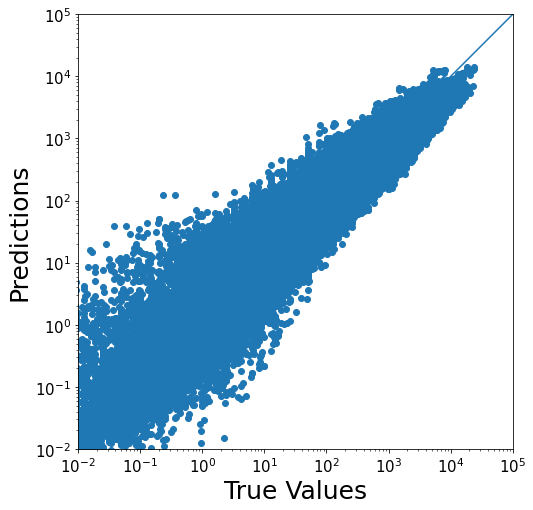

In [85]:
plt.rcParams["figure.figsize"] = (18,8)  # increase plot size

amin, amax = 1e-2, 10e4

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_num, test_predict1_self_ice_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

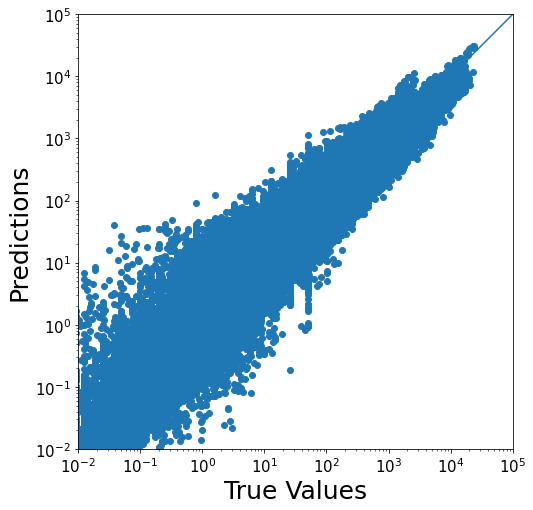

In [86]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_num, test_predict2_self_ice_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

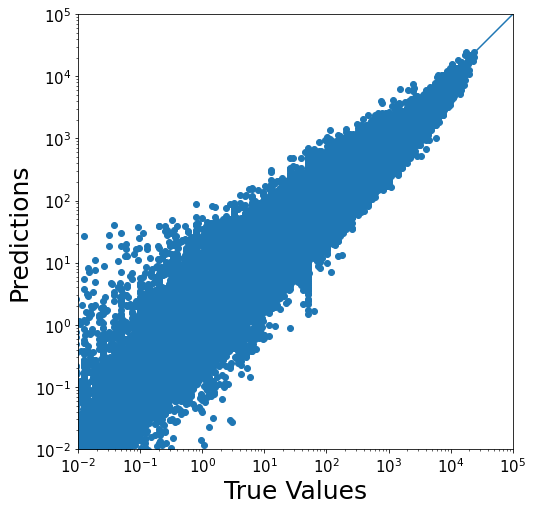

In [87]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_num, test_predict3_self_ice_num)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

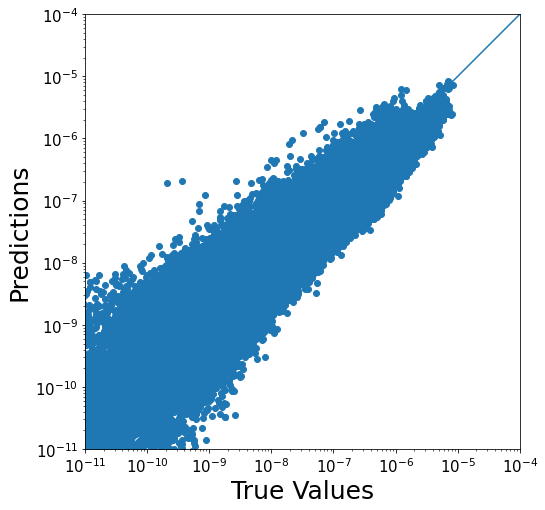

In [88]:
amin, amax = 1e-11, 1e-4

a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_mass, test_predict1_self_ice_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

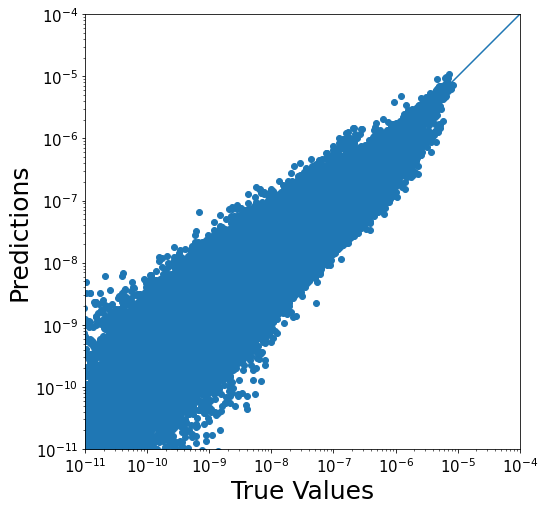

In [89]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_mass, test_predict2_self_ice_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

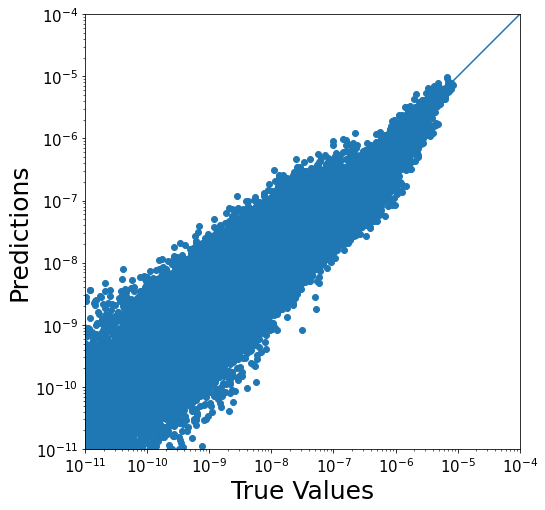

In [90]:
a = plt.axes(aspect='equal')
plt.scatter(test_true_self_ice_mass, test_predict3_self_ice_mass)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.yscale('log')
plt.xscale('log')
lims = [amin, amax]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

# Save models to file

In [91]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model_v2
   

In [92]:
def save2netcdf(model, features_str, labels_str, features_norm, labels_norm, features_ltf, outpath, verbose=True):
    # borrowed from Fabian Jakub, LMU Munich
    # https://github.com/tenstream/tenstream/blob/master/misc/LUT_to_Keras.py

    if model is None:
        D = xr.Dataset()
        D.to_netcdf(outpath)
        return

    layers = [ l for l in model.layers if 'Dropout' not in str(type(l)) ]
    if verbose:
        print("Saving model to "+outpath)
        print("  Features:   "+features_str)
        print("  Labels:     "+labels_str)
        for i,l in enumerate(layers):
            print("  Layer {}: {}, {}, Activation: {}".format(i, str(type(l)), l.weights[0].shape,l.activation.__name__))

    D = xr.Dataset()
    D.attrs['Nlayer'] = np.int32(len(layers))
    D.attrs['features']  = features_str
    D.attrs['labels'] = labels_str
    D.attrs['keras_name'] = model.name

    for i, l in enumerate(layers):
        D["w{}".format(i)] = xr.DataArray(l.weights[0].numpy(), dims=("Ninp_{}".format(i), "Nout_{}".format(i)))
        D["b{}".format(i)] = xr.DataArray(l.weights[1].numpy(), dims=("Nout_{}".format(i)))
        D["w{}".format(i)].attrs['activation'] = l.activation.__name__

        
    # write arrays for logtransform and normalization of input and output data to netcdf
    nout = len(layers)-1
    D["inp_logtransform"] = xr.DataArray(features_ltf, dims=("Ninp_0"))
    D["inp_norm_mean"] = xr.DataArray(features_norm['mean'].values, dims=("Ninp_0"))
    D["inp_norm_std"]  = xr.DataArray(features_norm['std'].values, dims=("Ninp_0"))
    D["out_norm_mean"] = xr.DataArray(labels_norm['mean'].values, dims=("Nout_{}".format(nout)))
    D["out_norm_std"]  = xr.DataArray(labels_norm['std'].values, dims=("Nout_{}".format(nout)))
    
    D.to_netcdf(outpath)

In [93]:
features = 'qi, ni'
labels   = 'self_ice_num, self_ice_mass'
filename = 'saved_model_v2/self_ice_model1_'+version+'.nc'
logtransform = np.array([True, True], dtype=bool)
save2netcdf(model1,features,labels,train_stats1,train_labels_stats,logtransform,filename)

Saving model to saved_model_v2/self_ice_model1_27.nc
  Features:   qi, ni
  Labels:     self_ice_num, self_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (2, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [94]:
features = 'qi, ni, temp, rho'
labels   = 'self_ice_num, self_ice_mass'
logtransform = np.array([True, True, False, False], dtype=bool)

save2netcdf(model2,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/self_ice_model2_'+version+'.nc')

Saving model to saved_model_v2/self_ice_model2_27.nc
  Features:   qi, ni, temp, rho
  Labels:     self_ice_num, self_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 16), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 16), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (16, 2), Activation: linear


In [95]:
save2netcdf(model3,features,labels,train_stats3,train_labels_stats,logtransform,'saved_model_v2/self_ice_model3_'+version+'.nc')

Saving model to saved_model_v2/self_ice_model3_27.nc
  Features:   qi, ni, temp, rho
  Labels:     self_ice_num, self_ice_mass
  Layer 0: <class 'tensorflow.python.keras.layers.core.Dense'>, (4, 32), Activation: relu
  Layer 1: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 2: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 32), Activation: relu
  Layer 3: <class 'tensorflow.python.keras.layers.core.Dense'>, (32, 2), Activation: linear
